In [3]:
import numpy as np
from nilearn import image

# Load power template coords
powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)
datpower = image.get_data(powerimg)

print(datpower.shape)

(91, 109, 91)


In [5]:
# Sort power coordinates

pcoords = []
proinums = []

for roi in range(264):
    x,y,z = np.where(datpower == roi+1)
    pcoords.append(np.stack([x,y,z,np.ones(x.shape[0])]).T)
    proinums.append(roi*np.ones(x.shape[0]))
    
pcoords = np.concatenate(pcoords).T
proinums = np.concatenate(proinums)

print(pcoords.shape)
print(proinums.shape)

(4, 21384)
(21384,)


In [1]:
from scipy.interpolate import interpn
from pathlib import Path
import re

# Extract timeseries quickly

funcdir = '/home/anton/Documents/Tulane/Research/UKBB/Cypress/func/'
exp = re.compile('(\d+)_(\d+)_(\d).+\.nii')

fnames = []

skipped = 0
for f in Path(funcdir).iterdir():
    res = exp.match(f.name)
    if not res:
        continue
    sub = res.group(1)
    task = res.group(2)
    ses = res.group(3)
        
    fnames.append(dict(fname=f.name, sub=sub, ses=ses, task=task))
    
fnames.sort(key=lambda a: a['fname'])
print(skipped)
print(len(fnames))
print(fnames[0])
print(fnames[1])

0
600
{'fname': '1000076_20227_2_0.nii', 'sub': '1000076', 'ses': '2', 'task': '20227'}
{'fname': '1000076_20227_3_0.nii', 'sub': '1000076', 'ses': '3', 'task': '20227'}


In [28]:
# Save coords for input into matlab
# Add 1 for matlab indexing
# Also save indexes of rois... add 1 for matlab indexing

fname = fnames[0]['fname']

imgname = f'{funcdir}/{fname}'
img = image.load_img(imgname)
datimg = image.get_data(img)

print(datimg.shape)

coords = np.linalg.inv(img.affine)@powerimg.affine@pcoords
points = [np.arange(s) for s in img.shape[:-1]]

print(coords[:,500])
print(points[1])

csvcoordname = '/home/anton/Documents/Tulane/Research/UKBB/Cypress/powercoords.csv'
csvidxname = '/home/anton/Documents/Tulane/Research/UKBB/Cypress/powerroiindex.csv'

with open(csvcoordname, 'w') as f:
    c = [','.join((coords[:-1,i]+1).astype('int').astype('str').tolist()) for i in range(coords.shape[1])]
    c = '\n'.join(c)
    f.write(c)
    
with open(csvidxname, 'w') as f:
    lns = (proinums+1).astype('int').astype('str').tolist()
    f.write('\n'.join(lns))

print('Done')

(79, 95, 79, 490)
[29. 41. 26.  1.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
Done


In [29]:
datimg[49,6,28,0]

1817

In [37]:
# Check timeseries against that computed by matlab

import pickle

ts = pickle.load(open('/home/anton/Documents/Tulane/Research/UKBB/Cypress/ts/ukb_ts_20227_0-600_nofilt.pkl',
                      'rb'))
print(ts['1000076'][0][2][263])

[10023.25925926  9884.95061728  9860.4691358   9849.11111111
  9810.66666667  9859.58024691  9794.88888889  9769.67901235
  9698.58024691  9666.37037037  9653.72839506  9660.90123457
  9635.39506173  9598.2345679   9646.92592593  9593.79012346
  9653.54320988  9588.74074074  9645.08641975  9660.97530864
  9675.79012346  9670.81481481  9634.92592593  9671.96296296
  9689.49382716  9641.96296296  9715.39506173  9657.
  9698.37037037  9660.50617284  9656.          9699.39506173
  9663.75308642  9711.54320988  9686.39506173  9665.44444444
  9679.12345679  9657.09876543  9663.59259259  9672.77777778
  9671.2962963   9695.62962963  9605.56790123  9642.51851852
  9618.33333333  9586.72839506  9644.44444444  9612.96296296
  9660.44444444  9583.12345679  9572.64197531  9569.14814815
  9633.04938272  9649.64197531  9620.55555556  9561.69135802
  9639.0617284   9610.0617284   9604.49382716  9604.87654321
  9626.49382716  9583.45679012  9566.80246914  9617.87654321
  9588.87654321  9597.51851852  

In [7]:
import pickle

tsdict = dict()

low = 0
inc = 600

for n in range(low,low+inc):
    if n >= len(fnames):
        break
    fname = fnames[n]['fname']
    sub = fnames[n]['sub']
    ses = fnames[n]['ses']
    task = fnames[n]['task']
    
    print(f'Doing {n} {fname}')
    
    imgname = f'{funcdir}/{fname}'
    img = image.load_img(imgname)
    datimg = image.get_data(img)
        
    coords = np.linalg.inv(img.affine)@powerimg.affine@pcoords
    points = [np.arange(s) for s in img.shape[:-1]]
        
    nt = datimg.shape[-1]
    ts = np.zeros((264,nt))
    res = np.zeros((nt,coords.shape[-1]))

    for tp in range(nt):
        res[tp] = interpn(points, datimg[:,:,:,tp], coords[:-1].T, bounds_error=False)

    for roi in range(264):
        ts[roi] = np.mean(res[:,proinums == roi], axis=1)
            
    val = (ses, task, ts)
    if sub in tsdict:
        tsdict[sub].append(val)
    else:
        tsdict[sub] = [val]
    
print('Complete')

with open(f'{funcdir}/../ts/ukb_ts_20227_{low}-{low+inc}_nofilt.pkl', 'wb') as f:
    pickle.dump(tsdict, f)
    
print('Wrote dict file')

Doing 0 1000076_20227_2_0.nii
Doing 1 1000076_20227_3_0.nii
Doing 2 1000211_20227_2_0.nii
Doing 3 1000302_20227_2_0.nii
Doing 4 1000302_20227_3_0.nii
Doing 5 1000465_20227_2_0.nii
Doing 6 1000515_20227_2_0.nii
Doing 7 1000531_20227_2_0.nii
Doing 8 1000655_20227_2_0.nii
Doing 9 1000732_20227_2_0.nii
Doing 10 1000744_20227_2_0.nii
Doing 11 1000763_20227_2_0.nii
Doing 12 1001026_20227_2_0.nii
Doing 13 1001026_20227_3_0.nii
Doing 14 1001044_20227_2_0.nii
Doing 15 1001063_20227_2_0.nii
Doing 16 1001090_20227_2_0.nii
Doing 17 1001195_20227_2_0.nii
Doing 18 1001210_20227_2_0.nii
Doing 19 1001252_20227_2_0.nii
Doing 20 1001276_20227_2_0.nii
Doing 21 1001382_20227_2_0.nii
Doing 22 1001464_20227_2_0.nii
Doing 23 1001464_20227_3_0.nii
Doing 24 1001527_20227_2_0.nii
Doing 25 1001592_20227_2_0.nii
Doing 26 1001678_20227_2_0.nii
Doing 27 1001738_20227_2_0.nii
Doing 28 1001742_20227_2_0.nii
Doing 29 1002068_20227_2_0.nii
Doing 30 1002095_20227_2_0.nii
Doing 31 1002279_20227_2_0.nii
Doing 32 1002493_2

Doing 260 1028465_20227_2_0.nii
Doing 261 1028582_20227_2_0.nii
Doing 262 1028689_20227_2_0.nii
Doing 263 1028726_20227_2_0.nii
Doing 264 1028775_20227_2_0.nii
Doing 265 1028874_20227_2_0.nii
Doing 266 1028921_20227_2_0.nii
Doing 267 1028950_20227_2_0.nii
Doing 268 1028998_20227_2_0.nii
Doing 269 1029006_20227_2_0.nii
Doing 270 1029065_20227_2_0.nii
Doing 271 1029100_20227_2_0.nii
Doing 272 1029117_20227_2_0.nii
Doing 273 1029356_20227_2_0.nii
Doing 274 1029380_20227_2_0.nii
Doing 275 1029526_20227_2_0.nii
Doing 276 1029662_20227_2_0.nii
Doing 277 1029662_20227_3_0.nii
Doing 278 1029685_20227_2_0.nii
Doing 279 1029978_20227_2_0.nii
Doing 280 1030098_20227_2_0.nii
Doing 281 1030154_20227_2_0.nii
Doing 282 1030393_20227_2_0.nii
Doing 283 1030407_20227_2_0.nii
Doing 284 1030490_20227_2_0.nii
Doing 285 1030490_20227_3_0.nii
Doing 286 1030538_20227_2_0.nii
Doing 287 1030706_20227_2_0.nii
Doing 288 1030706_20227_3_0.nii
Doing 289 1030815_20227_2_0.nii
Doing 290 1030866_20227_2_0.nii
Doing 29

Doing 517 1058172_20227_2_0.nii
Doing 518 1058189_20227_2_0.nii
Doing 519 1058243_20227_2_0.nii
Doing 520 1058277_20227_2_0.nii
Doing 521 1058476_20227_2_0.nii
Doing 522 1058491_20227_2_0.nii
Doing 523 1058723_20227_2_0.nii
Doing 524 1058895_20227_2_0.nii
Doing 525 1058895_20227_3_0.nii
Doing 526 1058978_20227_2_0.nii
Doing 527 1059052_20227_2_0.nii
Doing 528 1059087_20227_2_0.nii
Doing 529 1059246_20227_2_0.nii
Doing 530 1059329_20227_2_0.nii
Doing 531 1059801_20227_2_0.nii
Doing 532 1059905_20227_2_0.nii
Doing 533 1059905_20227_3_0.nii
Doing 534 1060011_20227_2_0.nii
Doing 535 1060177_20227_2_0.nii
Doing 536 1060177_20227_3_0.nii
Doing 537 1060198_20227_2_0.nii
Doing 538 1060248_20227_2_0.nii
Doing 539 1060304_20227_2_0.nii
Doing 540 1060320_20227_2_0.nii
Doing 541 1060333_20227_2_0.nii
Doing 542 1060516_20227_2_0.nii
Doing 543 1060613_20227_2_0.nii
Doing 544 1060656_20227_2_0.nii
Doing 545 1060674_20227_2_0.nii
Doing 546 1060699_20227_2_0.nii
Doing 547 1060949_20227_2_0.nii
Doing 54

In [1]:
# Filter and quality control timeseries

import pickle
import numpy as np

funcdir = '/home/anton/Documents/Tulane/Research/UKBB/Cypress/func/'
ts = pickle.load(open(f'{funcdir}/../ts/ukb_ts_20227_0-600_nofilt.pkl', 'rb'))

print(len(ts))

556


In [36]:
from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    normal_cutoff = [cutoff[0], cutoff[1]]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False, fs=fs)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 0.735

ts_filt = dict()
ps = []
i = 0

for sub,vals in ts.items():
    if sub not in ts_filt:
        ts_filt[sub] = []
    for val in vals:
        ses, task, ts0 = val
        ts1 = butter_bandpass_filter(ts0, [0.01, 0.15], 1/tr)
        ts_filt[sub].append((ses, task, ts1))
        ps.append(np.corrcoef(ts1))
        if np.sum(np.isnan(ps[-1])) > 0:
            print(f'Bad {sub} {ses}')
    if i % 50 == 0:
        print(f'Done {i}')
    i += 1
    
print('Complete')

Done 0
Done 50
Done 100
Done 150
Done 200
Done 250
Done 300
Done 350
Done 400
Done 450
Done 500
Done 550
Complete


In [28]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45, 
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132, 
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257, 
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8, 
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248, 
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


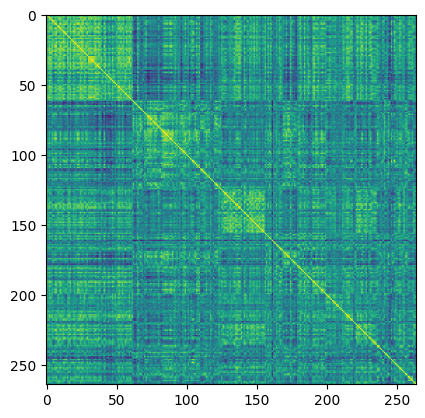

In [37]:
import matplotlib.pyplot as plt

p = ps[599]

plt.imshow(remap(p))
plt.show()

In [39]:
pickle.dump(ts_filt, open(f'{funcdir}/../ts/ukb_ts_20227_0-600_good_filt.pkl', 'wb'))

print('Done')

Done
